In [1]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time
import math
from sklearn.metrics import mean_squared_error
from scipy.linalg.interpolative import estimate_spectral_norm
from ipynb.fs.full.DBPCA import dbpca
from ipynb.fs.full.DBPCA import dbpca_with_forgetting_factor
from ipynb.fs.full.DBPCA import dbpca_with_forgetting_factor_v2
from ipynb.fs.full.Traditional_PCA import naive_pca_per_window
from ipynb.fs.full.Traditional_PCA import naive_pca_per_window_with_f
from ipynb.fs.full.Traditional_PCA import reconstruct_X
from ipynb.fs.full.SyntheticDataGeneration import generate_gaussian_dataset_concept_drift

In [2]:
def run_naive_pca(X, k, d, B, profiling=True):
    eig_vectors, Ys, Ms, execution_time = naive_pca_per_window(B, X, k, d, profiling)
    X_est = None
    for i, eig_vector in enumerate(eig_vectors):
        est = reconstruct_X(Ys[i], eig_vector, k).T + Ms[i]
        if X_est is None:
            X_est = est
        else:
            X_est = np.vstack((X_est, est))
    spectral_norm = estimate_spectral_norm((X - X_est))
    mse = mean_squared_error(X, X_est)
    return spectral_norm , mse, execution_time

In [3]:
def run_naive_pca_with_f(X, k, d, B, f, profiling=True):
    eig_vectors, Ys, Ms, Ws, execution_time = naive_pca_per_window_with_f(B, X, k, d, f, profiling)
    X_est = None
    W = None
    for i, eig_vector in enumerate(eig_vectors):
        est = reconstruct_X(Ys[i], eig_vector, k).T + Ms[i]
        if X_est is None:
            X_est = est
            W = Ws[i]
        else:
            X_est = np.vstack((X_est, est))
            W = np.vstack((W, Ws[i]))
    spectral_norm = estimate_spectral_norm((W - X_est))
    mse = mean_squared_error(W, X_est)
    return spectral_norm , mse, execution_time

In [4]:
d = 3
k = 3
ndist = 100
nobjects = 100
B = nobjects//4
X = generate_gaussian_dataset_concept_drift(nattr=d, ndist=ndist, nobjects=nobjects)
run_naive_pca(X, k, d, B, profiling=True)

(6.209150957911773e-14, 2.8250024725436793e-31, 0.05198097229003906)

In [5]:
def run_dbpca(X, k, d, B, profiling=True):
    Q, execution_time = dbpca(X, B, k, d, profiling)
    ## compute PCA 
    Y = X.T.dot(Q)
    ## get reconstruction
    X_est = Y.dot(Q.T)
    ## compute reconstruction error
    spectral_norm = estimate_spectral_norm((X - X_est.T))
    mse = mean_squared_error(X, X_est.T)
    return spectral_norm, mse, execution_time

In [6]:
def run_dbpca_with_Q_f(X, k, d, f, B, profiling=True):
    Q, execution_time = dbpca_with_forgetting_factor(B, X, k, d, f, profiling)
    ## compute PCA 
    Y = X.T.dot(Q)
    ## get reconstruction
    X_est = Y.dot(Q.T)
    ## compute reconstruction error
    spectral_norm = estimate_spectral_norm((X - X_est.T))
    mse = mean_squared_error(X, X_est.T)
    return spectral_norm, mse, execution_time

In [7]:
def run_dbpca_with_f_v2(X, k, d, f, B, profiling=True):
    Q, execution_time = dbpca_with_forgetting_factor_v2(B, X, k, d, f, profiling)
    ## compute PCA 
    Y = X.T.dot(Q)
    ## get reconstruction
    X_est = Y.dot(Q.T)
    ## compute reconstruction error
    spectral_norm = estimate_spectral_norm((X - X_est.T))
    mse = mean_squared_error(X, X_est.T)
    return spectral_norm, mse, execution_time

In [8]:
def run_various_f(X, F, k, d, nobjects, B_percentage=None, profiling=False):
    if B_percentage is None:
        B = nobjects
    else:
        B = nobjects * B_percentage
    spectral_norms = list()
    mses = list()
    fs = list()
    if profiling:
        execution_times = list()
    for f in F:
        if profiling:
            Q, execution_time = dbpca_with_forgetting_factor(B, X, k, d, f, profiling)
            execution_times.append(execution_time)
        else:
            Q = dbpca_with_forgetting_factor(B, X, k, d, f)
        ## compute PCA 
        Y = X.T.dot(Q)
        ## get reconstruction
        X_est = Y.dot(Q.T)
        ## compute reconstruction error
        spectral_norms.append(estimate_spectral_norm((X - X_est.T)))
        mses.append(mean_squared_error(X, X_est.T))
        fs.append(f)
    result = {}
    result['f'] = fs
    result['spectral_norm'] = spectral_norms
    result['mse'] = mses
    if profiling:
        result['execution_time'] = execution_times
    return pd.DataFrame(result)

## Functions for Graphics

In [9]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 6)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


In [10]:
def draw_simple_bar_chart(x_data, y_data, color, hatch, edgecolor, xlabel, ylabel, title):
    y_pos = np.arange(len(x_data))
    plt.bar(y_pos, y_data, align='center', alpha=0.5, 
            color=color, hatch=hatch, edgecolor=edgecolor)
    plt.xticks(y_pos, x_data)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

In [11]:
def draw_bar_chart(df, 
                   colors, 
                   hatch, 
                   figwidth=8, figheight=6,
                   vary_D=True):
    if vary_D:
        labels = df['d']
    else:
        labels = df['nobjects']
    fig, ax = plt.subplots(figsize=(figwidth *1.75, figheight))

    # set width of bar
    barWidth = 0.2

    # Set position of bar on X axis
    r1 = np.arange(len(labels))
#     r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r1]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]

    # Make the plot
    rects1 = ax.bar(r1, df['spectral_pca'],
                    color=colors[0],
                    width=barWidth, edgecolor='white',
                    label='naive pca',
                    hatch=hatch[0])
#     rects1 = ax.bar(r1, df['spectral_pca_f'],
#                     color=colors[1],
#                     width=barWidth, edgecolor='white',
#                     label='naive pca with f',
#                     hatch=hatch[1])
    rects3 = ax.bar(r3, df['spectral_dbpca'],
                    color=colors[2],
                    width=barWidth, edgecolor='white',
                    label='dbpca',
                    hatch=hatch[2])
    rects4 = ax.bar(r4, df['spectral_dbpcaQf'],
                    color=colors[3],
                    width=barWidth, edgecolor='white',
                    label='dbpca with f at Q',
                    hatch=hatch[3])
    rects5 = ax.bar(r5, df['spectral_dbpca_f'],
                    color=colors[4],
                    width=barWidth, edgecolor='white',
                    label='dbpca with f',
                    hatch=hatch[4])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Reconstruction error')
    if vary_D:
        ax.set_title('Dimension', y=-0.1)
    else:
        ax.set_title('Number of objects', y=-0.1)
    ax.set_xticks(r3)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [12]:
def draw_3bar_chart(df, 
                   colors, 
                   hatch, 
                   figwidth=8, figheight=6,
                   vary_D=True):
    if vary_D:
        labels = df['d']
    else:
        labels = df['nobjects']
    fig, ax = plt.subplots(figsize=(figwidth *1.75, figheight))

    # set width of bar
    barWidth = 0.2

    # Set position of bar on X axis
    r2 = np.arange(len(labels))
    r4 = [x + barWidth for x in r2]
    r5 = [x + barWidth for x in r4]

    # Make the plot
#     rects1 = ax.bar(r1, df['spectral_pca'],
#                     color=colors[0],
#                     width=barWidth, edgecolor='white',
#                     label='naive pca',
#                     hatch=hatch[0])
    rects2 = ax.bar(r2, df['spectral_pca_f'],
                    color=colors[1],
                    width=barWidth, edgecolor='white',
                    label='naive pca with f',
                    hatch=hatch[1])
#     rects3 = ax.bar(r3, df['spectral_dbpca'],
#                     color=colors[2],
#                     width=barWidth, edgecolor='white',
#                     label='dbpca',
#                     hatch=hatch[2])
    rects4 = ax.bar(r4, df['spectral_dbpcaQf'],
                    color=colors[3],
                    width=barWidth, edgecolor='white',
                    label='dbpca with f at Q',
                    hatch=hatch[3])
    rects5 = ax.bar(r5, df['spectral_dbpca_f'],
                    color=colors[4],
                    width=barWidth, edgecolor='white',
                    label='dbpca with f',
                    hatch=hatch[4])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Reconstruction error')
    if vary_D:
        ax.set_title('Dimension', y=-0.1)
    else:
        ax.set_title('Number of objects', y=-0.1)
    ax.set_xticks(r4)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [13]:
def draw_2bar_chart(df, 
                   colors, 
                   hatch, 
                   figwidth=8, figheight=6,
                   vary_D=True):
    if vary_D:
        labels = df['d']
    else:
        labels = df['nobjects']
    fig, ax = plt.subplots(figsize=(figwidth *1.75, figheight))

    # set width of bar
    barWidth = 0.2

    # Set position of bar on X axis
    r1 = np.arange(len(labels))
    r3 = [x + barWidth for x in r1]

    # Make the plot
    rects1 = ax.bar(r1, df['spectral_pca'],
                    color=colors[0],
                    width=barWidth, edgecolor='white',
                    label='naive pca',
                    hatch=hatch[0])
#     rects2 = ax.bar(r2, df['spectral_pca_f'],
#                     color=colors[1],
#                     width=barWidth, edgecolor='white',
#                     label='naive pca with f',
#                     hatch=hatch[1])
    rects3 = ax.bar(r3, df['spectral_dbpca'],
                    color=colors[2],
                    width=barWidth, edgecolor='white',
                    label='dbpca',
                    hatch=hatch[2])
#     rects4 = ax.bar(r4, df['spectral_dbpcaQf'],
#                     color=colors[3],
#                     width=barWidth, edgecolor='white',
#                     label='dbpca with f at Q',
#                     hatch=hatch[3])
#     rects5 = ax.bar(r5, df['spectral_dbpca_f'],
#                     color=colors[4],
#                     width=barWidth, edgecolor='white',
#                     label='dbpca with f',
#                     hatch=hatch[4])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Reconstruction error')
    if vary_D:
        ax.set_title('Dimension', y=-0.1)
    else:
        ax.set_title('Number of objects', y=-0.1)
    ax.set_xticks(r3)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [14]:
def draw_bar_chart_time(df, 
                   colors, 
                   hatch, 
                   figwidth=8, figheight=6,
                   vary_D=True):
    if vary_D:
        labels = df['d']
    else:
        labels = df['nobjects']
    fig, ax = plt.subplots(figsize=(figwidth *1.75, figheight))

    # set width of bar
    barWidth = 0.2

    # Set position of bar on X axis
    r1 = np.arange(len(labels))
#     r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r1]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]

    # Make the plot
    rects1 = ax.bar(r1, df['time_pca'],
                    color=colors[0],
                    width=barWidth, edgecolor='white',
                    label='naive pca',
                    hatch=hatch[0])
#     rects1 = ax.bar(r1, df['time_f'],
#                     color=colors[1],
#                     width=barWidth, edgecolor='white',
#                     label='naive pca with f',
#                     hatch=hatch[1])
    rects3 = ax.bar(r3, df['time_dbpca'],
                    color=colors[2],
                    width=barWidth, edgecolor='white',
                    label='dbpca',
                    hatch=hatch[2])
    rects4 = ax.bar(r4, df['time_dbpcaQf'],
                    color=colors[3],
                    width=barWidth, edgecolor='white',
                    label='dbpca with f at Q',
                    hatch=hatch[3])
    rects5 = ax.bar(r5, df['time_dbpca_f'],
                    color=colors[4],
                    width=barWidth, edgecolor='white',
                    label='dbpca with f',
                    hatch=hatch[4])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Running Time')
    if vary_D:
        ax.set_title('Dimension', y=-0.1)
    else:
        ax.set_title('Number of objects', y=-0.1)
    ax.set_xticks(r3)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [15]:
def run_experiments(f, D, K, ndist, nobjects, Bs, profiling=True):
    """
    f : forgetting factor
    D : list of dimension
    K : list of principal components
    ndist : number of distribution
    nobjects : number of objects per distribution
    B : window size
    profiling : check time
    """
    vary_D = False
    factor = len(nobjects)
    if len(D) > len(nobjects):
        vary_D = True
        factor = len(D)
    result = {}
    
    spectral_pca = []
    mse_pca = []
    execution_time_pca = []
    
    spectral_pca_f = []
    mse_pca_f = []
    execution_time_pca_f = []
    
    spectral_dbpca = []
    mse_dbpca = []
    execution_time_dbpca = []
    
    spectral_dbpcaQf = []
    mse_dbpcaQf = []
    execution_time_dbpcaQf = []   
    
    spectral_dbpca_f = []
    mse_dbpca_f = []
    execution_time_dbpca_f = []   
    
    arrival_rate = 0.0001 ## 10 milisecond
    for i in range(factor):
        if not vary_D:
            d = D[0]
            k = K[0]
            nobject = nobjects[i]
            B = nobject//4
        else:
            d = D[i]
            k = K[i]
            nobject = nobjects[0]
            B = Bs
        n = ndist * nobject
        X = generate_gaussian_dataset_concept_drift(nattr=d, ndist=ndist, nobjects=nobject)
        
        spectral_norm, mse, execution_time = run_naive_pca(X, k, d, B, profiling)
        total_time = n * arrival_rate + execution_time
        spectral_pca.append(spectral_norm)
        mse_pca.append(mse)
        execution_time_pca.append(total_time)
        
        spectral_norm, mse, execution_time = run_naive_pca_with_f(X, k, d, B, f, profiling)
        total_time = n * arrival_rate + execution_time
        spectral_pca_f.append(spectral_norm)
        mse_pca_f.append(mse)
        execution_time_pca_f.append(total_time)
        
        spectral_norm, mse, execution_time = run_dbpca(X.T, k, d, B, profiling)
        total_time = n * arrival_rate;
        if total_time > execution_time:
            execution_time = total_time
        spectral_dbpca.append(spectral_norm)
        mse_dbpca.append(mse)
        execution_time_dbpca.append(execution_time)
        
        spectral_norm, mse, execution_time = run_dbpca_with_Q_f(X.T, k, d, f, B, profiling)
        total_time = n * arrival_rate;
        if total_time > execution_time:
            execution_time = total_time
        spectral_dbpcaQf.append(spectral_norm)
        mse_dbpcaQf.append(mse)
        execution_time_dbpcaQf.append(execution_time)
        
        spectral_norm, mse, execution_time = run_dbpca_with_f_v2(X.T, k, d, f, B, profiling)
        total_time = n * arrival_rate;
        if total_time > execution_time:
            execution_time = total_time
        spectral_dbpca_f.append(spectral_norm)
        mse_dbpca_f.append(mse)
        execution_time_dbpca_f.append(execution_time)
    
    if vary_D:
        result['d'] = D
    else:
        result['nobjects'] = list(np.array(nobjects)*ndist)
    
    result['spectral_pca'] = spectral_pca
    result['mse_pca'] = mse_pca
    result['time_pca'] = execution_time_pca
    
    result['spectral_pca_f'] = spectral_pca_f
    result['mse_pca_f'] = mse_pca_f
    result['time_pca_f'] = execution_time_pca_f
    
    result['spectral_dbpca'] = spectral_dbpca
    result['mse_dbpca'] = mse_dbpca
    result['time_dbpca'] = execution_time_dbpca
    
    result['spectral_dbpcaQf'] = spectral_dbpcaQf
    result['mse_dbpcaQf'] = mse_dbpcaQf
    result['time_dbpcaQf'] = execution_time_dbpcaQf
    
    result['spectral_dbpca_f'] = spectral_dbpca_f
    result['mse_dbpca_f'] = mse_dbpca_f
    result['time_dbpca_f'] = execution_time_dbpca_f
    return pd.DataFrame(result)

## Experiment 1

In [16]:
d = 3
k = 3
ndist = 100
nobjects = 100
X = generate_gaussian_dataset_concept_drift(nattr=d, ndist=ndist, nobjects=nobjects)
X = X.T
F = np.array(range(1,11))*0.1
df_various_f = run_various_f(X, F, k, d, nobjects, B_percentage=None, profiling=True)
df_various_f

,f,spectral_norm,mse,execution_time
0,0.1,6.806549e-14,1.894744e-31,0.048429
1,0.2,6.806549e-14,1.894744e-31,0.046574
2,0.3,3.333751e-14,5.633605e-32,0.043786
3,0.4,6.806549e-14,1.894744e-31,0.045781
4,0.5,3.314388e-14,5.052969e-32,0.044382
5,0.6,3.333751e-14,5.633605e-32,0.044755
6,0.7,3.979886e-14,7.914245e-32,0.044489
7,0.8,6.806549e-14,1.894744e-31,0.046427
8,0.9,9.101127e-14,2.951208e-31,0.044036
9,1.0,3.314388e-14,5.052969e-32,0.044057


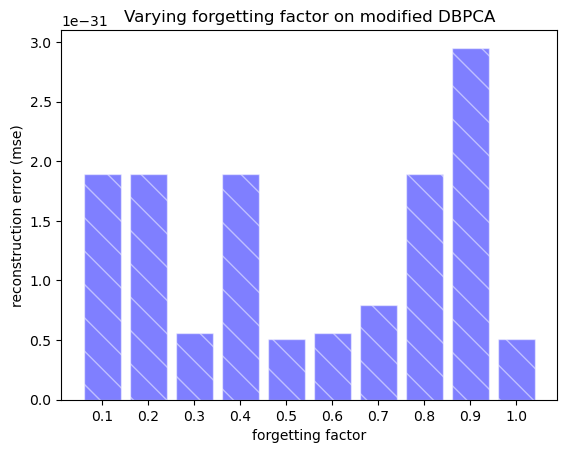

In [17]:
x_data = df_various_f['f'].round(1)
y_data = df_various_f['mse']
ylabel = 'reconstruction error (mse)'
xlabel = 'forgetting factor'
title = 'Varying forgetting factor on modified DBPCA'
color = 'blue'
hatch = '\\'
edgecolor = 'white'
draw_simple_bar_chart(x_data, y_data, color, hatch, edgecolor, xlabel, ylabel, title)

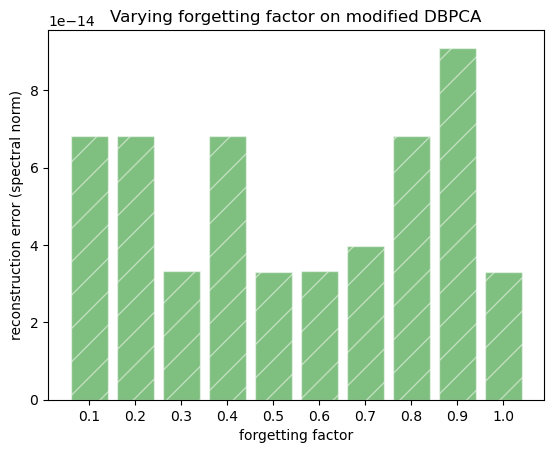

In [18]:
x_data = df_various_f['f'].round(1)
y_data = df_various_f['spectral_norm']
ylabel = 'reconstruction error (spectral norm)'
xlabel = 'forgetting factor'
title = 'Varying forgetting factor on modified DBPCA'
color = 'green'
hatch = '/'
edgecolor = 'white'
draw_simple_bar_chart(x_data, y_data, color, hatch, edgecolor, xlabel, ylabel, title)

Let's compare execution time with the PCA algorithm

Put together different approaches:

    - offline pca
    - offline pca with forgetting factor for each point
    - dbpca
    - dbpca with forgetting factor on Q 
    - dbpca with forgetting factor for each point

## Experiment 2

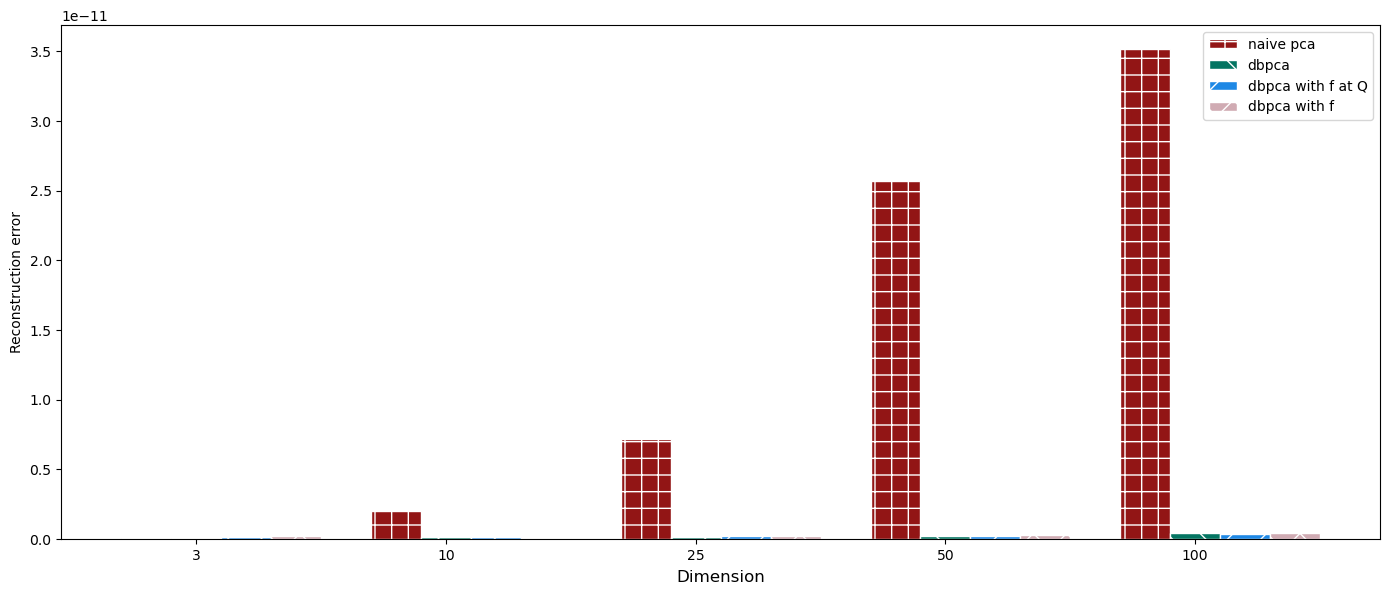

In [19]:
## Assumption : the arrival rate is fixed in order to know the window size
def run_experiments_vary_d():
    f = 0.4
    D = [3, 10, 25, 50, 100]
    K = D
    ndist = 10
    nobjects = [1000,]
    profiling = True
    Bs = nobjects[0]/4
    df = run_experiments(f, D, K, ndist, nobjects, Bs, profiling=True)
    return df
#df = run_experiments_vary_d()
#df.to_pickle("./fixed_10k_objects.pickle")
df = pd.read_pickle("./fixed_10k_objects.pickle")
draw_bar_chart(df, 
               colors=('#921515', '#420420', '#047562', '#1E88E5', '#d0abb3'), 
               hatch=('+','-', '\\', '/', 'x'), 
               figwidth=8, figheight=6, vary_D=True)

## Experiment 3

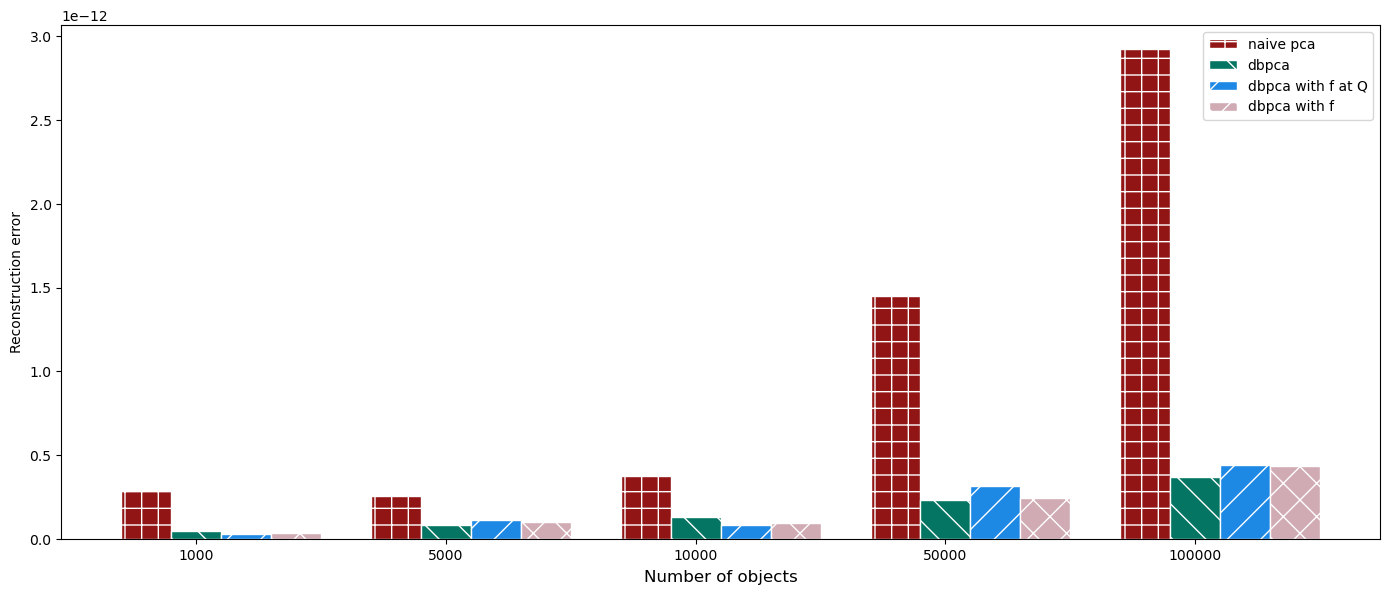

In [20]:
def run_experiments_vary_nobjects():
    f = 0.4
    D = [10,]
    K = D
    ndist = 10
    nobjects = [100, 500, 1000, 5000, 10000]
    profiling = True
    df = run_experiments(f, D, K, ndist, nobjects, Bs=None, profiling=True)
    return df

df2 = run_experiments_vary_nobjects()
df2.to_pickle("./fixed_10_d.pickle")
draw_bar_chart(df2, 
               colors=('#921515', '#420420', '#047562', '#1E88E5', '#d0abb3'), 
               hatch=('+','-', '\\', '/', 'x'), 
               figwidth=8, figheight=6, vary_D=False)

In [21]:
df2

,nobjects,spectral_pca,mse_pca,time_pca,spectral_pca_f,mse_pca_f,time_pca_f,spectral_dbpca,mse_dbpca,time_dbpca,spectral_dbpcaQf,mse_dbpcaQf,time_dbpcaQf,spectral_dbpca_f,mse_dbpca_f,time_dbpca_f
0,1000,2.895340e-13,2.538042e-29,0.106987,1.808671e-12,1.015183e-27,0.109998,4.506065e-14,4.577406e-31,0.1,3.234769e-14,3.115345e-31,0.1,3.772890e-14,3.594479e-31,0.1
1,5000,2.592921e-13,7.969854e-30,0.507717,2.149707e-24,3.478606e-52,0.508005,8.321997e-14,3.793514e-31,0.5,1.120083e-13,5.577766e-31,0.5,1.006887e-13,4.508541e-31,0.5
2,10000,3.767745e-13,7.659830e-30,1.008303,5.078807e-39,7.171394e-82,1.008566,1.283967e-13,3.872862e-31,1.0,8.105723e-14,2.047375e-31,1.0,9.389908e-14,2.559021e-31,1.0
3,50000,1.450788e-12,1.642493e-29,5.015152,0.000000e+00,2.075076e-322,5.017783,2.334129e-13,2.954512e-31,5.0,3.149382e-13,4.622496e-31,5.0,2.414401e-13,2.745804e-31,5.0
4,100000,2.922374e-12,4.014759e-29,10.026082,0.000000e+00,0.000000e+00,10.028996,3.709831e-13,3.895248e-31,10.0,4.423826e-13,4.879376e-31,10.0,4.375452e-13,3.893330e-31,10.0


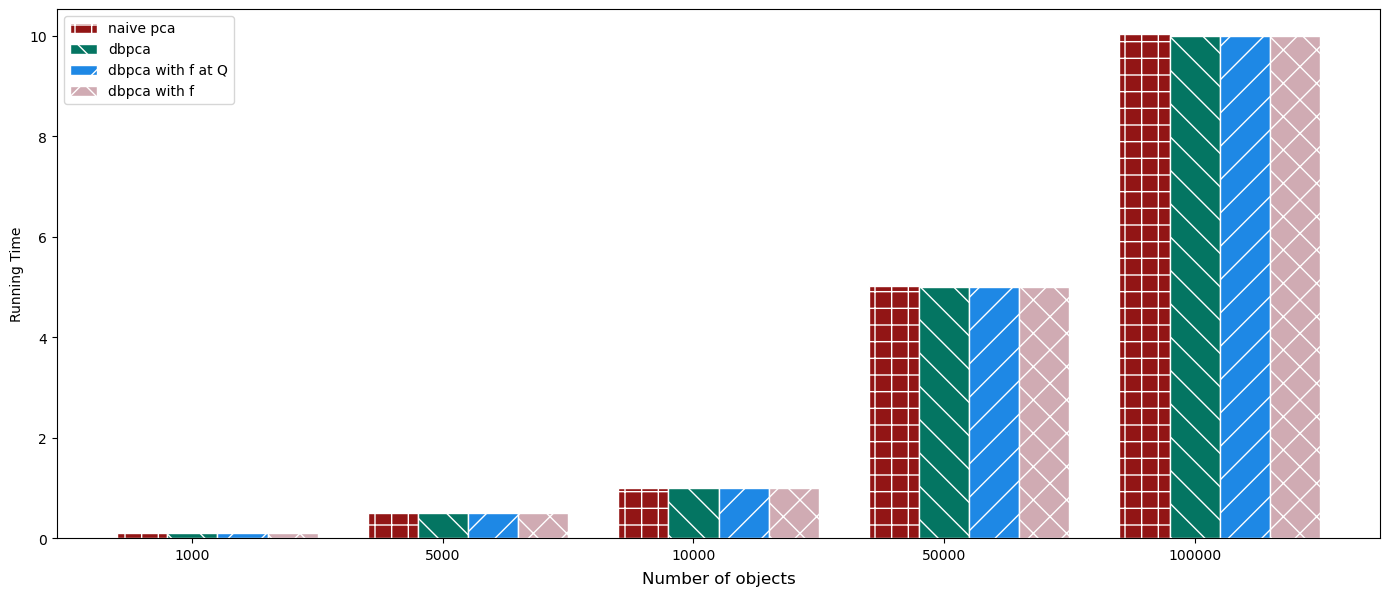

In [22]:
draw_bar_chart_time(df2, 
               colors=('#921515', '#420420', '#047562', '#1E88E5', '#d0abb3'), 
               hatch=('+','-', '\\', '/', 'x'), 
               figwidth=8, figheight=6, vary_D=False)

Forgetting factor is all about application. 
Red and green do not meet the requirement of data stream.... 
My data has forgetting factor, if I ignore it (using the naive pca and dbpca) ...
Next: do like CF Tree to build inlier class from estimated value (of outlier object)

## Experiments 4

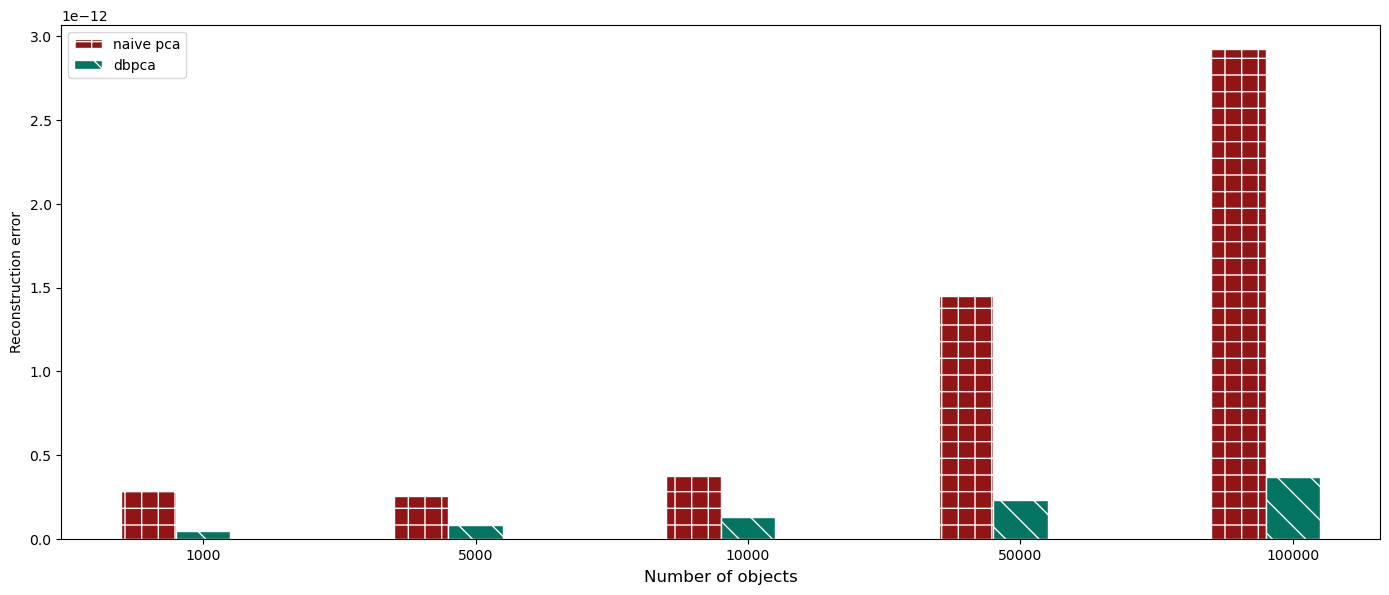

In [23]:
draw_2bar_chart(df2, 
               colors=('#921515', '#420420', '#047562', '#1E88E5', '#d0abb3'), 
               hatch=('+','-', '\\', '/', 'x'), 
               figwidth=8, figheight=6, vary_D=False)

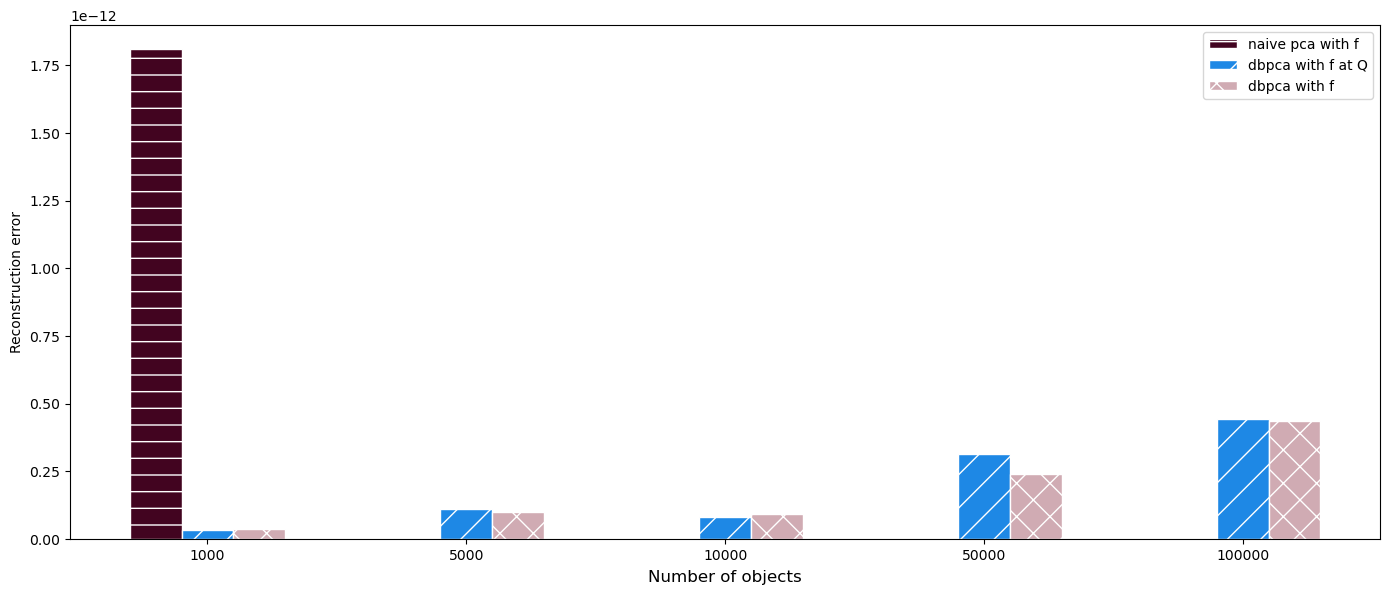

In [24]:
draw_3bar_chart(df2, 
               colors=('#921515', '#420420', '#047562', '#1E88E5', '#d0abb3'), 
               hatch=('+','-', '\\', '/', 'x'), 
               figwidth=8, figheight=6, vary_D=False)